## Load and classify spikes. Summarize across regions
Once single units are identified, we must determine which ones meet the criteria for corresponding to an individual neuron. Several metrics are used, some based on the properties of the spike times, and others on the shape of the extracellular spike waveform. One can also examine the likelihood that two single units will be confused with each other, but that will be left for a seperate demo.

Each metric can be added to the data class we use to represent our single units. This allows us to select only those units that meet minimum quality standards. Or, we can stratify the results of analyses by the score a unit received on a particular metric, allowing us to determine if it is sensitive to the degree of single unit isolation.

For more details about spike sorting and the intepretation of extracellular spike waveforms, check out our [short course](https://github.com/dbheadley/SpikeSortShortCourse).

In [1]:
import sys
import pynapple as nap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from numpy.linalg import svd
from mimo_pack.fileio.loadphy import as_pynapple
from mimo_pack.fileio.spikeglx import get_bin_memmap, get_geommap
from mimo_pack.preprocess.unit import mean_waveform, waveform_halfwidth, waveform_peak, classify_unit

### Primary auditory cortex

In [2]:
bin_path = "D:\\SortingTemp\\24-05-31_DH23_A1-IC_g0\\24-05-31_DH23_A1-IC_g0_imec0\\24-05-31_DH23_A1-IC_g0_t0.imec0.ap.bin"
pre = 1
post = 2
fs = 30000

pre_samp = int(pre*fs/1000)
post_samp = int(post*fs/1000)

# open binary file, read only
bin_mm = get_bin_memmap(bin_path)

# get channel positions
gmap = get_geommap(bin_path)

In [3]:
phy_dir = 'D:\\SortingTemp\\24-05-31_DH23_A1-IC_g0\\24-05-31_DH23_A1-IC_g0_imec0\\kilosort4\\'
spks = as_pynapple(phy_dir, suffix='_sas')
spks_a1 = spks.getby_category('SASLabel')['SU']

           SASLabel
cluster_id         
0             Noise
1                SU
2                SU
3                MU
4                MU
...             ...
766              SU
767              SU
768              MU
769              MU
770              SU

[701 rows x 1 columns]


In [4]:
waveforms = np.zeros((len(spks_a1), 90, 384))
for i, unit in enumerate(spks_a1.items()):
    times = unit[1].times()
    waveforms[i],_ = mean_waveform(times, bin_mm)

# identify channel with max
max_chan = np.argmax(np.linalg.norm(waveforms, axis=1), axis=1)

# get waveform at max channel
unit_wave = waveforms[range(waveforms.shape[0]), :, max_chan]

# get position of unit
unit_pos = gmap[max_chan, 1:3]

fr_a1 = spks_a1.get_info('rate')

In [5]:
fr_a1 = spks_a1.get_info('rate')

In [6]:
unit_ids = spks_a1.keys()

# get unit waveform properties
unit_widths = np.zeros((len(spks_a1),))
unit_peaks = np.zeros((len(spks_a1),))
for i in range(waveforms.shape[0]):
    unit_widths[i] = waveform_halfwidth(unit_wave[i])
    _, unit_peaks[i] = waveform_peak(unit_wave[i])


In [7]:
def split_copy(array, *args, **kwargs):
    return [np.copy(x) for x in np.split(array, *args, **kwargs)]

In [8]:
# create spike properties dataframe
spk_props = pd.DataFrame({'cluster_id': unit_ids, 'halfwidth': unit_widths, 'firing_rate': fr_a1, 
                         'peak': unit_peaks, 'x': unit_pos[:,0], 'y': unit_pos[:,1], 'wave': split_copy(unit_wave, unit_wave.shape[0])})
spk_props.set_index('cluster_id', inplace=True)

# classify units
spk_props['unit_type'] = spk_props.apply(lambda x: classify_unit(x['firing_rate'], x['halfwidth']), axis=1)

# remove unclassified units
spk_props = spk_props[spk_props['peak'] < 0]
spk_props = spk_props[spk_props['unit_type'] != 'UN']
spk_props['unit_type'].value_counts()

fr_a1 = spk_props['firing_rate']

c:\Users\dbh60\.conda\envs\AudAD\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\dbh60\.conda\envs\AudAD\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\dbh60\.conda\envs\AudAD\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\dbh60\.conda\envs\AudAD\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


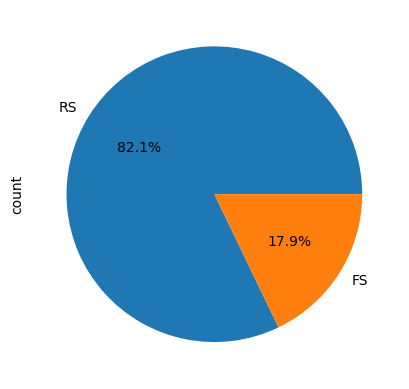

In [9]:
# pie chart of unit types
fig = plt.figure()
spk_props['unit_type'].value_counts().plot.pie(autopct='%1.1f%%')
fig.savefig('../figures/grant/cell_types_pie_a1.pdf')

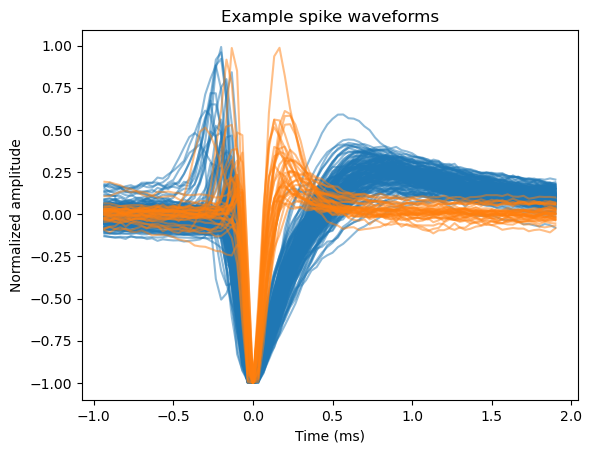

In [10]:
# plot example spike waveforms for RS and FS cells
fs_waves = spk_props[spk_props['unit_type'] == 'FS']['wave'].values
rs_waves = spk_props[spk_props['unit_type'] == 'RS']['wave'].values

# for each wave shift the negative peak to be at 30 samples
for i in range(len(fs_waves)):
    fs_waves[i] = np.roll(fs_waves[i], 30 - np.argmin(fs_waves[i]))
for i in range(len(rs_waves)):
    rs_waves[i] = np.roll(rs_waves[i], 30 - np.argmin(rs_waves[i]))

# concatenate the first 5 fs_waves into a single 2d array
fs_waves = np.concatenate(fs_waves, axis=0).T
fs_waves_norm = fs_waves / np.max(np.abs(fs_waves), axis=0)
rs_waves = np.concatenate(rs_waves, axis=0).T
rs_waves_norm = rs_waves / np.max(np.abs(rs_waves), axis=0)
t_pts = np.arange(-28, 58)/30
fig = plt.figure()
plt.plot(t_pts, rs_waves_norm[2:-2], color='tab:blue', alpha=0.5)
plt.plot(t_pts, fs_waves_norm[2:-2], color='tab:orange', alpha=0.5)
plt.xlabel('Time (ms)')
plt.ylabel('Normalized amplitude')
plt.title('Example spike waveforms')

fig.savefig('../figures/grant/example_waveforms_a1.pdf')


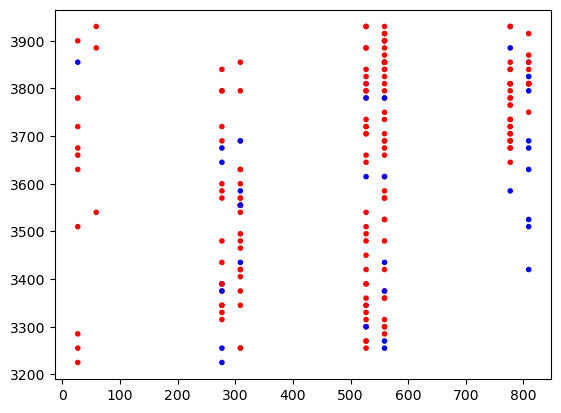

In [11]:
spk_props.to_csv('D:\\SortingTemp\\24-05-31_DH23_A1-IC_g0\\24-05-31_DH23_A1-IC_g0_imec0\\spk_props.csv')

# plot spk properties x and y with different colors for different unit types
plt.scatter(spk_props['x'], spk_props['y'], c=spk_props['unit_type'].map({'FS': 'blue', 'RS': 'red', 'UN': 'white'}), marker='.')

### Inferior colliculus

In [12]:
bin_path = "D:\\SortingTemp\\24-05-31_DH23_A1-IC_g0\\24-05-31_DH23_A1-IC_g0_imec1\\24-05-31_DH23_A1-IC_g0_t0.imec1.ap.bin"
pre = 1
post = 2
fs = 30000

pre_samp = int(pre*fs/1000)
post_samp = int(post*fs/1000)

# open binary file, read only
bin_mm = get_bin_memmap(bin_path)

# get channel positions
gmap = get_geommap(bin_path)

phy_dir = "D:\\SortingTemp\\24-05-31_DH23_A1-IC_g0\\24-05-31_DH23_A1-IC_g0_imec1\\kilosort4\\"
spks_ic = as_pynapple(phy_dir, suffix='_sas')
spks_ic = spks_ic.getby_category('SASLabel')['SU']

           SASLabel
cluster_id         
0                SU
1                MU
2                MU
3                MU
4                SU
...             ...
721              SU
722              SU
723              SU
724              SU
725              MU

[573 rows x 1 columns]


(array([ 0.,  0.,  1.,  0.,  0.,  4.,  4., 16., 19., 20., 23., 29., 26.,
        29., 38., 31., 37., 24., 30., 22., 17.,  7.,  2.,  2.]),
 array([-3.        , -2.79166667, -2.58333333, -2.375     , -2.16666667,
        -1.95833333, -1.75      , -1.54166667, -1.33333333, -1.125     ,
        -0.91666667, -0.70833333, -0.5       , -0.29166667, -0.08333333,
         0.125     ,  0.33333333,  0.54166667,  0.75      ,  0.95833333,
         1.16666667,  1.375     ,  1.58333333,  1.79166667,  2.        ]),
 <BarContainer object of 24 artists>)

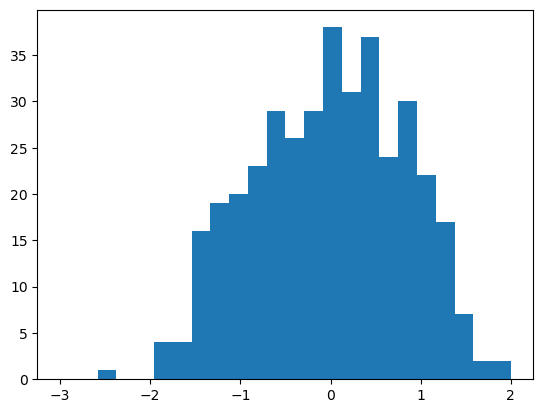

In [13]:
fr_ic = spks_ic.get_info('rate')
plt.hist(np.log10(fr_ic), np.linspace(-3, 2, 25))


### Lateral entorhinal cortex

In [14]:
bin_path = "D:\\SortingTemp\\24-06-03_DH23_LEC-LL_g0\\24-06-03_DH23_LEC-LL_g0_imec0\\24-06-03_DH23_LEC-LL_g0_t0.imec0.ap.bin"
pre = 1
post = 2
fs = 30000

pre_samp = int(pre*fs/1000)
post_samp = int(post*fs/1000)

# open binary file, read only
bin_mm = get_bin_memmap(bin_path)

# get channel positions
gmap = get_geommap(bin_path)

phy_dir = "D:\\SortingTemp\\24-06-03_DH23_LEC-LL_g0\\24-06-03_DH23_LEC-LL_g0_imec0\\kilosort4\\"
spks_lec = as_pynapple(phy_dir, suffix='_sas')
spks_lec = spks_lec.getby_category('SASLabel')['SU']

           SASLabel
cluster_id         
0             Noise
1                MU
2                SU
3                MU
4                SU
...             ...
710              SU
711              MU
712              SU
713              MU
714              MU

[672 rows x 1 columns]


(array([ 0.,  0.,  1.,  0.,  1.,  1.,  2.,  4.,  3.,  5., 11., 18., 18.,
        38., 67., 49., 26., 23., 14.,  4.,  3.,  1.,  0.,  0.]),
 array([-3.        , -2.79166667, -2.58333333, -2.375     , -2.16666667,
        -1.95833333, -1.75      , -1.54166667, -1.33333333, -1.125     ,
        -0.91666667, -0.70833333, -0.5       , -0.29166667, -0.08333333,
         0.125     ,  0.33333333,  0.54166667,  0.75      ,  0.95833333,
         1.16666667,  1.375     ,  1.58333333,  1.79166667,  2.        ]),
 <BarContainer object of 24 artists>)

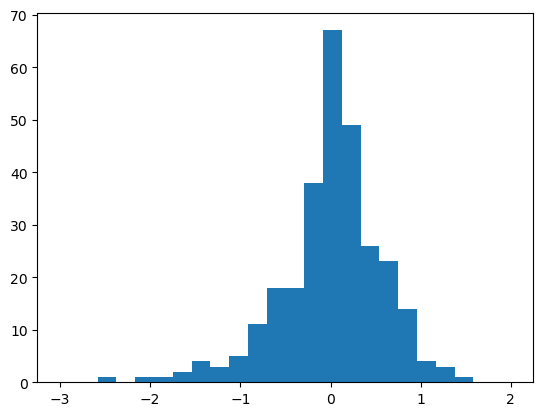

In [15]:
fr_lec = spks_lec.get_info('rate')
plt.hist(np.log10(fr_lec), np.linspace(-3, 2, 25))

### Lateral lemniscus

In [16]:
bin_path = "D:\\SortingTemp\\24-06-03_DH23_LEC-LL_g0\\24-06-03_DH23_LEC-LL_g0_imec1\\24-06-03_DH23_LEC-LL_g0_t0.imec1.ap.bin"
pre = 1
post = 2
fs = 30000

pre_samp = int(pre*fs/1000)
post_samp = int(post*fs/1000)

# open binary file, read only
bin_mm = get_bin_memmap(bin_path)

# get channel positions
gmap = get_geommap(bin_path)

phy_dir = "D:\\SortingTemp\\24-06-03_DH23_LEC-LL_g0\\24-06-03_DH23_LEC-LL_g0_imec1\\kilosort4\\"
spks_ll = as_pynapple(phy_dir, suffix='_sas')
spks_ll = spks_ll.getby_category('SASLabel')['SU']

           SASLabel
cluster_id         
0                MU
1                MU
2                MU
3                SU
4                MU
...             ...
437              MU
438              MU
439              SU
440              MU
441              MU

[335 rows x 1 columns]


(array([ 0.,  0.,  0.,  0.,  4.,  4.,  8., 13., 14.,  8., 12.,  9., 14.,
        20., 23., 12., 16., 10.,  7., 11.,  5.,  5.,  0.,  0.]),
 array([-3.        , -2.77083333, -2.54166667, -2.3125    , -2.08333333,
        -1.85416667, -1.625     , -1.39583333, -1.16666667, -0.9375    ,
        -0.70833333, -0.47916667, -0.25      , -0.02083333,  0.20833333,
         0.4375    ,  0.66666667,  0.89583333,  1.125     ,  1.35416667,
         1.58333333,  1.8125    ,  2.04166667,  2.27083333,  2.5       ]),
 <BarContainer object of 24 artists>)

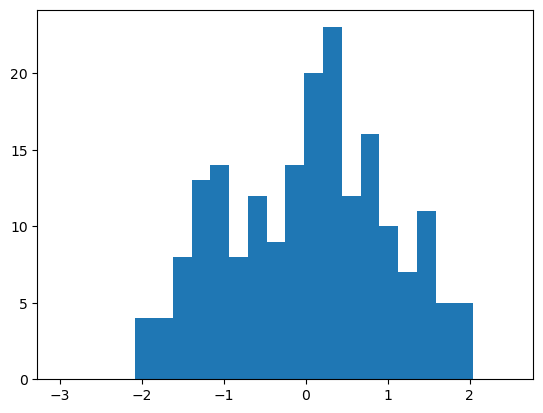

In [17]:
fr_ll = spks_ll.get_info('rate')
plt.hist(np.log10(fr_ll), np.linspace(-3, 2.5, 25))

array([1.e-02, 2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02,
       9.e-02, 1.e-01, 2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01,
       8.e-01, 9.e-01, 1.e+00, 2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00,
       7.e+00, 8.e+00, 9.e+00, 1.e+01, 2.e+01, 3.e+01, 4.e+01, 5.e+01,
       6.e+01, 7.e+01, 8.e+01, 9.e+01, 1.e+02, 2.e+02, 3.e+02, 4.e+02,
       5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02])

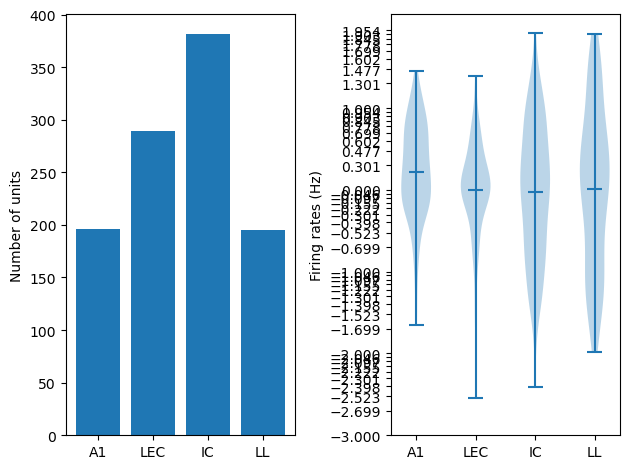

In [26]:
fig, ax = plt.subplots(1,2)
ax[0].bar([1, 2, 3, 4], [len(fr_a1), len(fr_lec), len(fr_ic), len(fr_ll)])
ax[0].set_xticks([1, 2, 3, 4])
ax[0].set_xticklabels(['A1', 'LEC', 'IC', 'LL'])
ax[0].set_ylabel('Number of units')
ax[1].violinplot([np.log10(fr_a1), np.log10(fr_lec), np.log10(fr_ic), np.log10(fr_ll)], showextrema=True, showmeans=True)
ax[1].set_xticks([1, 2, 3, 4])
ax[1].set_xticklabels(['A1', 'LEC', 'IC', 'LL'])
logTicks = np.log10((np.arange(1, 10)*np.array([0.001, 0.01, 0.1, 1, 10])[:,np.newaxis]).ravel())
ax[1].set_yticks(logTicks)
ax[1].set_ylabel('Firing rates (Hz)')
fig.tight_layout()

fig.savefig('../figures/grant/num_units_fr.pdf')

### Load spiking data
Single unit spike times, cluster IDs, and waveforms are loaded from Phy compatible files.

Index    rate
-------  --------
0        1.68213
1        0.6188
2        5.65923
3        4.07561
4        14.96972
5        0.10543
6        0.23481
...      ...
764      10.12453
765      8.05819
766      15.21623
767      14.28832
768      9.72477
769      8.24472
770      5.49346
           SASLabel
cluster_id         
0             Noise
1                SU
2                SU
3                MU
4                MU
...             ...
766              SU
767              SU
768              MU
769              MU
770              SU

[701 rows x 1 columns]


In [22]:
spks

Index    rate      SASLabel
-------  --------  ----------
1        0.6188    SU
2        5.65923   SU
5        0.10543   SU
6        0.23481   SU
8        9.91904   SU
10       6.98857   SU
12       3.60647   SU
...      ...       ...
762      10.36467  SU
763      17.17966  SU
764      10.12453  SU
765      8.05819   SU
766      15.21623  SU
767      14.28832  SU
770      5.49346   SU

In [20]:
spks_su

Index    rate      SASLabel
-------  --------  ----------
1        0.6188    SU
2        5.65923   SU
5        0.10543   SU
6        0.23481   SU
8        9.91904   SU
10       6.98857   SU
12       3.60647   SU
...      ...       ...
762      10.36467  SU
763      17.17966  SU
764      10.12453  SU
765      8.05819   SU
766      15.21623  SU
767      14.28832  SU
770      5.49346   SU

### Recording efficacy
Before evaluating the quality of single units, we should determine if the recording they are derived from is good. Specifically, we want to identify periods where there is no spiking across all recorded units. Such an occurrence suggests that a disconnection or disruption of the recording system occurred.

In [3]:
bin_dur = 60 # seconds, 1 minute

# beginning and end of session
sess_int = spks.time_support
sess_dur = (sess_int['end'].values-sess_int['start'].values)/60

# bin all spikes into 1 minute bins
spks_bin_1min = spks.count(bin_dur)

# identify periods where spikes occurred
spk_present = np.any(spks_bin_1min.values!=0,axis=1)
spk_tot = np.sum(spk_present)*bin_dur/60

print('Total recording time: {:0.0f} minutes'.format(sess_dur[0]))
print('Total spiking time: {:0.0f} minutes'.format(spk_tot))
print('Percent time without spikes: {:0.0f}%'.format(spk_tot/sess_dur[0]*100))

Total recording time: 220 minutes
Total spiking time: 177 minutes
Percent time without spikes: 81%


Since we are missing spikes from almost 20% of the recording, let's see where.

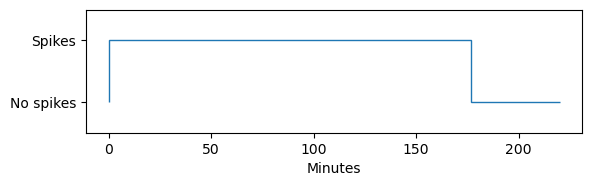

In [4]:
bin_times = spks_bin_1min.index.values
bin_edges = np.hstack((bin_times - bin_dur/2, bin_times[-1] + bin_dur/2))
fig, ax = plt.subplots()
ax.stairs(spk_present,bin_edges/60)
ax.set_ylim([-0.5, 1.5])
ax.set_yticks([0,1])
ax.set_yticklabels(['No spikes', 'Spikes'])
ax.set_xlabel('Minutes')
ax.set_aspect(30)
plt.show()

It appears that all unit activity ceased around 170 minutes into the recording. Further work with this dataset should exclude this period from analysis.

### Firing rate
Each class of neurons in a given brain region has a characteristic distribution of mean firing rates. Focusing on the cortex, where our neurons are often recorded, this distribution is log-normal with a median rate around 2.5 Hz and a maximum of 30 Hz. Some types of neurons, such as fast-spiking interneurons, tend to have higher firing rates than others (>~5 Hz). If a single unit's firing rate exceeds 50 Hz, it is likely comprised of multiple neurons whose spikes were grouped together. Single unit's with firing rates below 0.1 Hz may have too few spikes for subsequent analyses.

Conveniently, the time series group object in pynapple that stores our single units has a function for calculating firing rate. For a given single unit, it measures firing rate between its first and last spikes, so we don't have to worry about accounting for the disconnection we uncovered above.

In [5]:
# the pynapple time series group calculates firing rate
fr_arr = spks.get_info('rate')
print(fr_arr)

0     1.393359
1     1.743313
2     1.165271
3     3.276152
4     2.325227
5     1.337096
6      1.86214
7     2.619145
8     7.492296
9     3.419277
10      5.6256
11    7.598064
12    6.824507
13    2.901142
14    3.750248
Name: rate, dtype: object


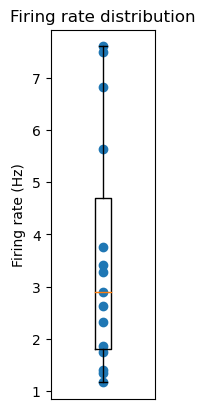

In [6]:
# Plotting the distribution of firing rates
fig, ax = plt.subplots()
ax.boxplot(fr_arr.values)
ax.scatter(np.ones(fr_arr.size),fr_arr)
ax.set_aspect(0.5)
ax.set_ylabel('Firing rate (Hz)')
ax.set_xticks([])
ax.set_title('Firing rate distribution')
plt.show()

### Inter-spike interval distribution
Besides their mean firing rates, single neurons also exhibit characteristic distributions in the time intervals between their spikes. These are referred to as inter-spike interval (ISI) distributions. They tend to be log-normal, and sometimes exhibit multiple peaks indicating different firing modes, such as bursting.

Since neurons have an absolute refractory period, there should be a paucity of ISIs with lags on the order of a few milliseconds. We can check for this by finding the ISI below which only 5% of spikes occurred. The higher this number is, the more likely we are dealing with a single neuron.

In [7]:
# ISI distribution
def isi_dist_calc(spks):
    isi_bins = np.logspace(-4,1,100,base=10) # log intervals because ISIs are long-tailed
    hist_data = np.histogram(np.diff(spks.index.values),isi_bins)
    return hist_data

# ISI below which 5% of spikes occurred
def isi_coff_func(isi_data):
    isi_cp = np.cumsum(isi_data['isi_vals'])/np.sum(isi_data['isi_vals'])
    isi_cutoff = isi_data['isi_bins'][np.nonzero((isi_cp)>0.05)[0][0]]
    return isi_cutoff 

In [8]:
# calculate isi distribution for each spike
isi_dict = {}
for id,data in spks.items():
    isi_dict[id] = isi_dist_calc(data)

# convert to dataframe
isi_df = pd.DataFrame().from_dict(isi_dict,orient='index',columns=['isi_vals','isi_bins'])
isi_df.index.name = 'clu_id'

# calculate ISI below which 5% of spikes occurred
isi_df['isi_cutoff'] = isi_df.apply(isi_coff_func, axis=1)
print('ISI 5% cutoffs in seconds:\n{}'.format(isi_df['isi_cutoff']))

# add to our spike times data
spks.set_info(isi_cutoff=isi_df['isi_cutoff'])

ISI 5% cutoffs in seconds:
clu_id
0     0.010476
1     0.010476
2     0.013219
3     0.005857
4     0.009326
5     0.009326
6     0.010476
7     0.013219
8     0.005214
9     0.016681
10    0.011768
11    0.005857
12    0.007391
13    0.013219
14    0.010476
Name: isi_cutoff, dtype: float64


Most of these are above 10 ms, which suggests that the spikes from our single units are distributing themselves as if they were generated by a single neuron with a refactory period. 

Plotting the ISI distributions will help us appreciate their variety of forms.

In [9]:
# plots ISI distrbution along with 5% cutoff
def isi_plot(isi_vals, isi_bins, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    # find the time when more than 0.5% of ISIs remain
    cutoff = isi_bins[np.nonzero((np.cumsum(isi_vals)/np.sum(isi_bins))>0.05)[0][0]]
    isi_prob = isi_vals/np.sum(isi_vals)
    ax.plot(isi_bins[1:],isi_prob)
    ax.fill(isi_bins[1:],isi_prob,alpha=0.3)
    ax.set_xscale('log')
    
    ax.set_ylim([0, 0.05])
    ax.set_xlim(isi_bins[[0,-1]])
    ax.axvline(cutoff,color='r')    

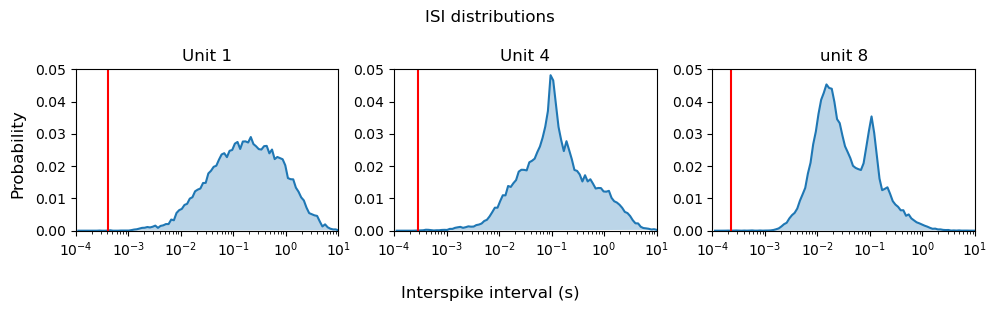

In [10]:
fig, ax = plt.subplots(1,3)
isi_plot(isi_df.loc[1,'isi_vals'],isi_df.loc[1,'isi_bins'],ax=ax[0])
isi_plot(isi_df.loc[4,'isi_vals'],isi_df.loc[4,'isi_bins'],ax=ax[1])
isi_plot(isi_df.loc[8,'isi_vals'],isi_df.loc[8,'isi_bins'],ax=ax[2])
fig.set_size_inches(10,3)
ax[0].set_title('Unit 1')
ax[1].set_title('Unit 4')
ax[2].set_title('unit 8')
fig.supylabel('Probability')
fig.supxlabel('Interspike interval (s)')
fig.suptitle('ISI distributions')
fig.tight_layout()
plt.show()

All show a base log-normal distribution. Some also exhibit additional peaks reflecting other firing modes.

### False positive rate
We can further exploit the refractory period by measuring the degree to which spikes violate it. This can be formalized as a ratio of the rate of observed violations over the predicated rate of violations from a unit with the same firing rate but no refractory period. The higher this value is, the less likely the single unit reflects an individual neuron. A typical cutoff is 0.5, meaning that the number of violations are half of what would be expected from a unit with no refractory period.

Below is a function for calculating this. We set the refractory period to 3 ms.

In [11]:
def refract_fp(spks):
    refract = 0.003 # setting refractory period
    num_spks = spks.size
    dur = spks[-1]-spks[0] # total duration of spiking
    viol_count = np.sum(np.diff(spks)<=refract) # number of refractory period violations
    refract_time = 2*refract*num_spks # total potential time for refractory period violations
    spk_rate = num_spks/dur # mean firing rate, irrespective of refractory period
    viol_rate = viol_count/refract_time # firing rate just during the refractory period
    r_fp = viol_rate/spk_rate # ratio of observed to predicted violations
    return r_fp

In [12]:
# calculate false positive rates for refractory period
fp_dict = {}
for id,data in spks.items():
    fp_dict[id] = refract_fp(data.index.values)
fp_ser = pd.Series(fp_dict,name='fp_rate')
fp_ser.index.name = 'clu_id'
print('The false positive rates for our single units:\n{}'.format(fp_ser))
spks.set_info(ref_fp=fp_ser)

The false positive rates for our single units:
clu_id
0     0.823968
1     0.576433
2     0.397710
3     0.520653
4     0.642635
5     0.347583
6     0.481905
7     0.007424
8     0.169459
9     0.084494
10    0.239217
11    0.346641
12    0.350922
13    0.315144
14    0.165004
Name: fp_rate, dtype: float64


It is easier to visualize this with a histogram.

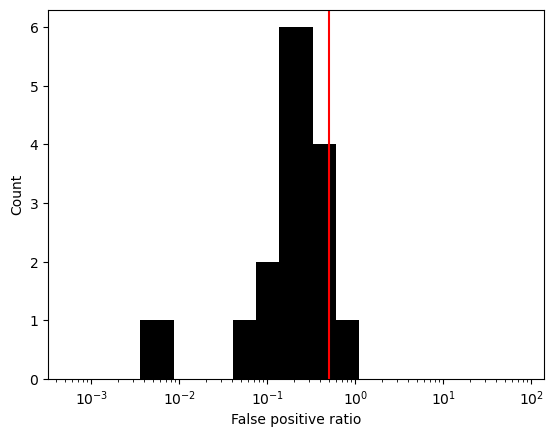

In [13]:
r_fp_hist = np.histogram(fp_ser.values,np.logspace(-3,2,20))
fig, ax = plt.subplots()
ax.bar(r_fp_hist[1][:-1], r_fp_hist[0], np.diff(r_fp_hist[1]),color='k')
ax.set_xscale('log')
ax.axvline(0.5,color='r')
ax.set_ylabel('Count')
ax.set_xlabel('False positive ratio')
plt.show()

Note that most of our units are below the 0.5 cutoff. In addition, our distribution is similar to ones reported for Neuropixel recordings by the [Allen Institute](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html#ISI-violations).

### Coincident spike ratio
Sometimes two single units will share the same spikes due to errors in the clustering algorithm. For instance, if a unit has a very large, highly variable, spike waveform then subtracting its mean template leaves a spike-like residual that gets clustered as a different unit. To account for this, we can detect the number of near coincident spikes between any two single units, and then compare it with the number of coincidences expected by chance. 

In [14]:
# calculate rate of near-coincident spikes for each pair
spks_coi = nap.compute_crosscorrelogram(spks,binsize=0.00025,windowsize=0.00099,norm=True)
spks_coi = spks_coi.apply(np.ptp)
spks_coi.name = 'coin_rate'
spks_coi

0   1     1.375364
    2     1.683511
    3     2.328650
    4     1.781101
    5     3.260375
            ...   
11  13    1.639602
    14    1.236398
12  13    0.997095
    14    1.068008
13  14    2.847308
Name: coin_rate, Length: 105, dtype: float64

The cross-correlogram function with in pynapple normalizes by the firing rate of the target (postsynaptic) unit. Thus, a value greater than 1 indicates that the firing rate of the target unit is greater than would be expected by chance. Let's plot the distribution of these values:

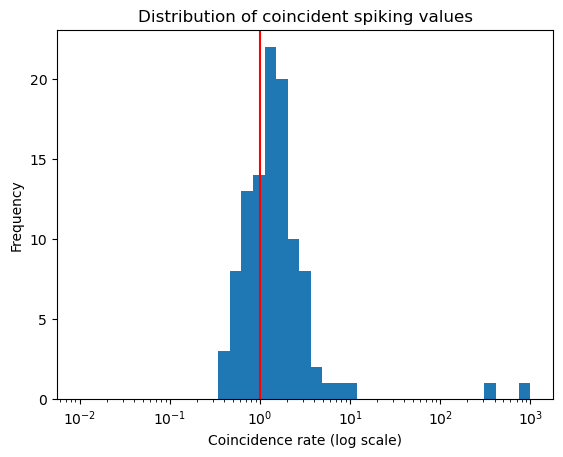

In [15]:
# calculate histogram using pandas's built-in function
ax = spks_coi.plot.hist(bins=np.logspace(-2,3,40))
ax.set_xscale('log')
ax.set_xlabel('Coincidence rate (log scale)')
ax.set_title('Distribution of coincident spiking values')
ax.axvline(1,color='r')

Notice that the distribution is just centered near 1, with a couple pairs of neurons having a coincidence rate in excess of 100. We can plot which pairs have this high value.

In [16]:
bad_pairs = spks_coi.index[spks_coi>100].values
print('Excess coincidence pairs are:\n{}'.format(bad_pairs))

Excess coincidence pairs are:
[(5, 7) (9, 13)]


To diagnose the problem, it helps to examine their spike waveforms. If these pairs have similar waveforms, it might be a result of misclassification, or over-clustering.

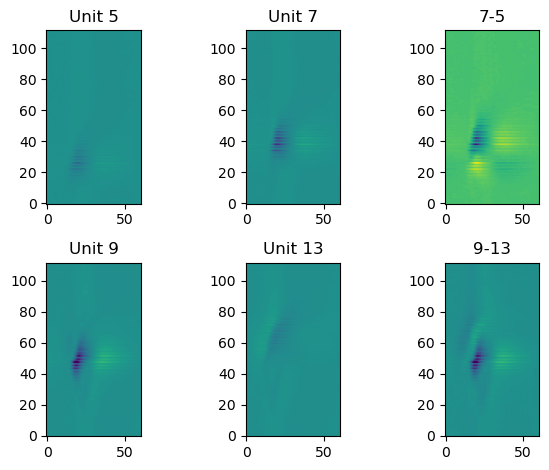

In [17]:
spk_waves = spks.get_info('full_wave')
fig, ax = plt.subplots(2,3)
ax[0,0].imshow(spk_waves[5].T,vmin=-100,vmax=100)
ax[0,0].set_title('Unit 5')
ax[0,0].invert_yaxis()
ax[0,1].imshow(spk_waves[7].T,vmin=-100,vmax=100)
ax[0,1].set_title('Unit 7')
ax[0,1].invert_yaxis()
ax[0,2].imshow(spk_waves[7].T-spk_waves[5].T)
ax[0,2].set_title('7-5')
ax[0,2].invert_yaxis()
ax[1,0].imshow(spk_waves[9].T,vmin=-100,vmax=100)
ax[1,0].set_title('Unit 9')
ax[1,0].invert_yaxis()
ax[1,1].imshow(spk_waves[13].T,vmin=-100,vmax=100)
ax[1,1].set_title('Unit 13')
ax[1,1].invert_yaxis()
ax[1,2].imshow(spk_waves[9].T-spk_waves[13].T,vmin=-100,vmax=100)
ax[1,2].set_title('9-13')
ax[1,2].invert_yaxis()
fig.tight_layout()

The waveforms are not too similar, so it is not obvious that they are misclassified or over-clustered. It is worth noting that the waveform amplitudes for Unit 5 and 13 are substantially smaller than their counterparts, which may indicate that they are capturing residuals left. However, a greater depth of analysis would be required to explore this possibility then is warrented in this tutorial. Thus, we will leave them as is.

### Spike amplitude
The amplitude of a spike is related to the morphology of the neuron it originates from and its distance from the recording electrode. Generally, the farther a neuron's soma is from the electrode, the smaller its spike waveform amplitude. Larger neurons with most of their dendrites directed in a specific direction (e.g. layer 5 pyramidal neurons) will also produce larger amplitudes. 

The smaller a single unit's spike waveform amplitude, the harder it is to reliably detect from the background noise of the recording.

In [18]:
# get the spike waveform from the electrode where it was strongest
spk_pwaves = spks.get_info('peak_wave')
spk_amps = spk_pwaves.apply(lambda x: np.max(np.abs(x)))
spk_amps.index.name = 'clu_id'
spk_amps.name = 'amp'
print('Spike waveform amplitudes:\n{}'.format(spk_amps))

Spike waveform amplitudes:
clu_id
0      22
1      20
2      29
3      17
4      26
5      35
6      42
7      81
8      56
9     142
10     33
11     25
12     21
13     17
14     66
Name: amp, dtype: int16


Keep in mind that these values are derived from the templates.npy file, which stores voltages in terms of the ADC conversion number used by the Neuropixel probe. To turn these into microvolts (uV), we need a conversion factor. This can be calculated based on the gain of the amplifier, bit depth of the ADC, and voltage range of the ADC. Recordings from the Intan Technologies system the conversion factor is fixed at 0.195uV. For Neuropixel 1.0 recordings, it can be calculated based on the .meta file associated with the recording. Let's perform this calcuation based on the recording we are analyzing now. The specification for the .meta file can be found [here](https://billkarsh.github.io/SpikeGLX/Sgl_help/Metadata_30.html).

In [19]:
v_range = 1.2 # imAiRangeMax - imAiRangeMin
adc_bitdepth = 10 # Neuropixel 1.0 probes have 10 bit ADCs
amp_gain = 500 # taken from imroTbl 
v_to_uv = 10**6

conv_uv = (v_range/(2**adc_bitdepth)/amp_gain)*v_to_uv

Text(0.5, 1.0, 'Distribution of spike waveform peak voltages')

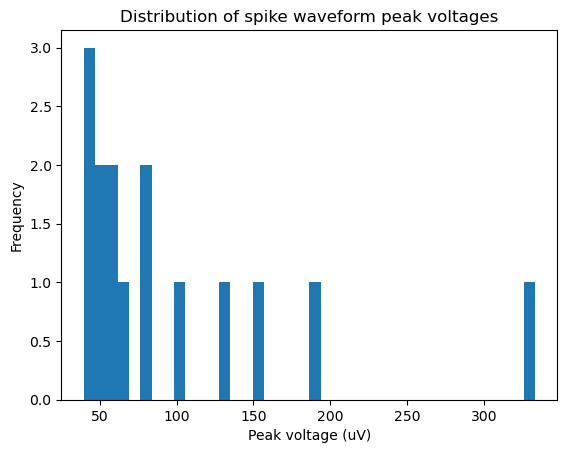

In [20]:
spk_amps = spk_amps*conv_uv
ax = spk_amps.plot.hist(bins=40)
ax.set_xlabel('Peak voltage (uV)')
ax.set_title('Distribution of spike waveform peak voltages')

A typical cutoff for single unit amplitudes is ~50 uV. If a unit has an amplitude in excess of 2 mV, that usually indicates it is artifactual (unless one is recording with sharpened tungsten electrodes). High quality units will usually have an amplitude greater than 100 uV.